# Improvements for concatenated GLCM models (with final train + save)

In [1]:
import sys
import os
from git_root import git_root

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.optimizers import Adam

sys.path.append(git_root("utils"))
from utils import load_config, load_params

sys.path.append(git_root("models"))
from validation_utils import plot_history
from affine_scalar_layer import AffineScalar

sys.path.append(git_root("training"))
from fetch_data import fetch_data_local
from fetch_data import to_numpy_arrays, prepare_tf_dataset

In [2]:
print(tf.__version__)

2.0.0


In [3]:
config, params = load_config(), load_params()

In [4]:
angles = params["GLCM"]["mel_map"]["angles_in_deg"]

In [5]:
train = {
    "spectrogram": {0: []},
    "mel_map": {
        angle: [] for angle in angles
    }
}
test = {
    "spectrogram": {0: []},
    "mel_map": {
        angle: [] for angle in angles
    }
}

In [6]:
for map_type in train:
    for angle in train[map_type]:
        print(f"Map: {map_type}, angle: {angle}")
        train[map_type][angle] = fetch_data_local(
            map_type=map_type, train=True, angle=angle
        )
        test[map_type][angle] = fetch_data_local(
            map_type=map_type, train=False, angle=angle
        )

Map: spectrogram, angle: 0
Fetching: data_spectrogram_angle_0_train.json
Fetching: data_spectrogram_angle_0_test.json
Map: mel_map, angle: 0
Fetching: data_mel_map_angle_0_train.json
Fetching: data_mel_map_angle_0_test.json
Map: mel_map, angle: 45
Fetching: data_mel_map_angle_45_train.json
Fetching: data_mel_map_angle_45_test.json
Map: mel_map, angle: 90
Fetching: data_mel_map_angle_90_train.json
Fetching: data_mel_map_angle_90_test.json
Map: mel_map, angle: 135
Fetching: data_mel_map_angle_135_train.json
Fetching: data_mel_map_angle_135_test.json


In [7]:
for map_type in train:
    for angle in train[map_type]:
        print(f"Map: {map_type}, angle: {angle}")
        print("train")
        print(train[map_type][angle].shape)
        print("test")
        print(test[map_type][angle].shape)

Map: spectrogram, angle: 0
train
(12600, 4)
test
(1400, 4)
Map: mel_map, angle: 0
train
(12600, 4)
test
(1400, 4)
Map: mel_map, angle: 45
train
(12600, 4)
test
(1400, 4)
Map: mel_map, angle: 90
train
(12600, 4)
test
(1400, 4)
Map: mel_map, angle: 135
train
(12600, 4)
test
(1400, 4)


In [8]:
for map_type in train:
    for angle in train[map_type]:
        train[map_type][angle] = to_numpy_arrays(
            train[map_type][angle]
        )
        test[map_type][angle] = to_numpy_arrays(
            test[map_type][angle]
        )

In [9]:
for map_type in train:
    for angle in train[map_type]:
        print(f"Map: {map_type}, angle: {angle}")
        print("train")
        print(len(train[map_type][angle][0]))
        print(len(train[map_type][angle][1]))
        print("test")
        print(len(test[map_type][angle][0]))
        print(len(test[map_type][angle][1]))

Map: spectrogram, angle: 0
train
12600
12600
test
1400
1400
Map: mel_map, angle: 0
train
12600
12600
test
1400
1400
Map: mel_map, angle: 45
train
12600
12600
test
1400
1400
Map: mel_map, angle: 90
train
12600
12600
test
1400
1400
Map: mel_map, angle: 135
train
12600
12600
test
1400
1400


### Build concatenated dataset

In [10]:
BATCH_SIZE = 32

In [11]:
train_ds = tf.data.Dataset.from_tensor_slices(
    (
        (
            train["mel_map"][0][0],
            train["mel_map"][45][0],
            train["mel_map"][90][0],
            train["mel_map"][135][0]
        ),
        train["mel_map"][0][1]
    )
).shuffle(128).batch(BATCH_SIZE)
train_ds = train_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)
test_ds = tf.data.Dataset.from_tensor_slices(
    (
        (
            test["mel_map"][0][0],
            test["mel_map"][45][0],
            test["mel_map"][90][0],
            test["mel_map"][135][0]
        ),
        test["mel_map"][0][1]
    )
).shuffle(128).batch(BATCH_SIZE)
test_ds = test_ds.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [12]:
print(f"Map: stacked mel_maps")
tr_sample_batch, tr_label_batch = next(iter(train_ds))
te_sample_batch, te_label_batch = next(iter(test_ds))
print("train")
print(
    tr_sample_batch[0].shape,
    tr_sample_batch[1].shape,
    tr_sample_batch[2].shape,
    tr_sample_batch[3].shape,
    tr_label_batch.shape
)
print("test")
print(
    te_sample_batch[0].shape,
    te_sample_batch[1].shape,
    te_sample_batch[2].shape,
    te_sample_batch[3].shape,
    te_label_batch.shape
)

Map: stacked mel_maps
train
(32, 15, 15, 1) (32, 15, 15, 1) (32, 15, 15, 1) (32, 15, 15, 1) (32,)
test
(32, 15, 15, 1) (32, 15, 15, 1) (32, 15, 15, 1) (32, 15, 15, 1) (32,)


## Set up model

In [13]:
inputs_0 = keras.Input(shape=(15, 15, 1))
inputs_45 = keras.Input(shape=(15, 15, 1))
inputs_90 = keras.Input(shape=(15, 15, 1))
inputs_135 = keras.Input(shape=(15, 15, 1))

In [14]:
x0 = layers.Conv2D(
    12, (6, 6), activation="tanh", name="conv1_0"
)(inputs_0)
x0 = layers.AveragePooling2D((2, 2), name="pooling1_0")(x0)
x0 = AffineScalar(name="affine_0", suffix=0)(x0)
x0 = layers.Conv2D(6, (3,3), activation="tanh", name="conv2_0")(x0)
x0 = layers.GlobalAveragePooling2D(name="pooling2_0")(x0)

In [15]:
x45 = layers.Conv2D(
    12, (6, 6), activation="tanh", name="conv1_45"
)(inputs_45)
x45 = layers.AveragePooling2D((2, 2), name="pooling1_45")(x45)
x45 = AffineScalar(name="affine_45", suffix=45)(x45)
x45 = layers.Conv2D(6, (3,3), activation="tanh", name="conv2_45")(x45)
x45 = layers.GlobalAveragePooling2D(name="pooling2_45")(x45)

In [16]:
x90 = layers.Conv2D(
    12, (6, 6), activation="tanh", name="conv1_90"
)(inputs_90)
x90 = layers.AveragePooling2D((2, 2), name="pooling1_90")(x90)
x90 = AffineScalar(name="affine_90", suffix=90)(x90)
x90 = layers.Conv2D(6, (3,3), activation="tanh", name="conv2_90")(x90)
x90 = layers.GlobalAveragePooling2D(name="pooling2_90")(x90)

In [17]:
x135 = layers.Conv2D(
    12, (6, 6), activation="tanh", name="conv1_135"
)(inputs_135)
x135 = layers.AveragePooling2D((2, 2), name="pooling1_135")(x135)
x135 = AffineScalar(name="affine_135", suffix=135)(x135)
x135 = layers.Conv2D(6, (3,3), activation="tanh", name="conv2_135")(x135)
x135 = layers.GlobalAveragePooling2D(name="pooling2_135")(x135)

In [18]:
concatenated = layers.concatenate([x0, x45, x90, x135])
out = layers.Dense(10, activation="softmax", name="dense")(
    concatenated
)

In [19]:
model = keras.Model(
    inputs=[inputs_0, inputs_45, inputs_90, inputs_135],
    outputs=out
)

In [20]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 15, 15, 1)]  0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 15, 15, 1)]  0                                            
__________________________________________________________________________________________________
input_3 (InputLayer)            [(None, 15, 15, 1)]  0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 15, 15, 1)]  0                                            
______________________________________________________________________________________________

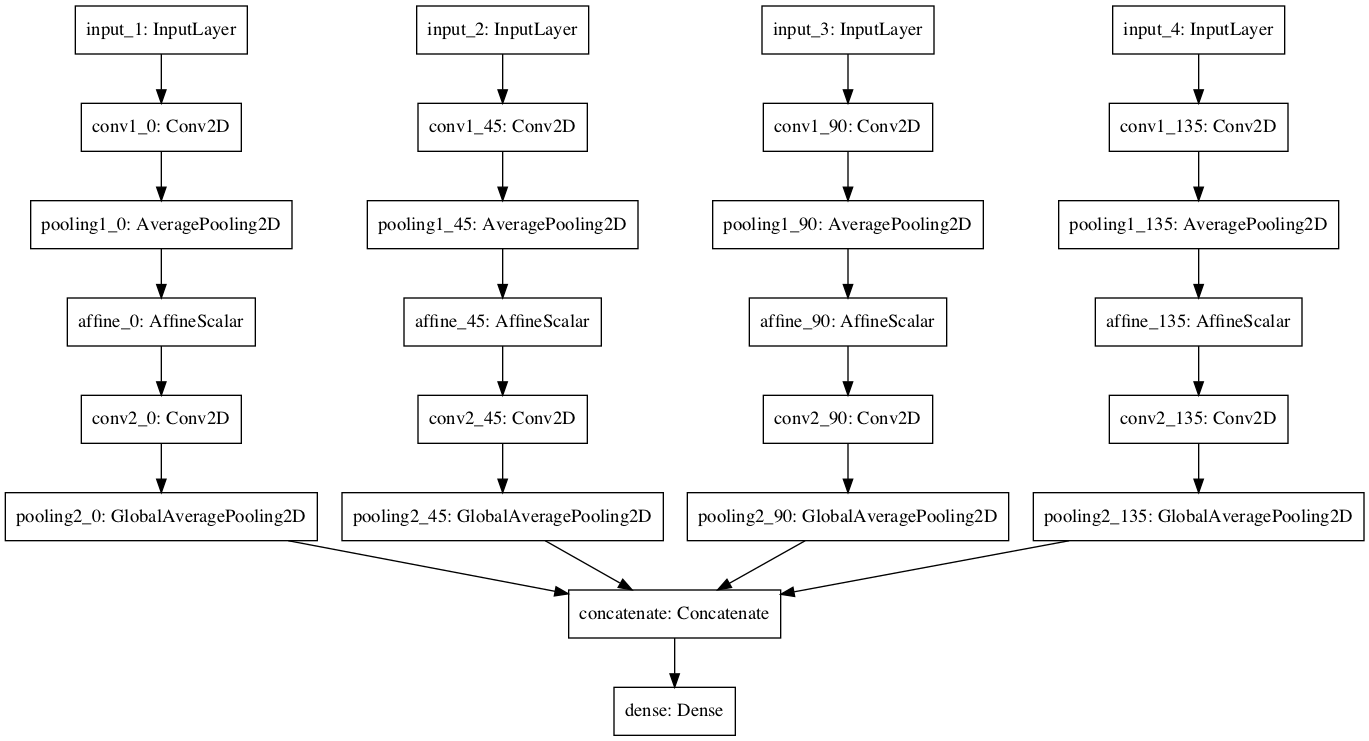

In [21]:
keras.utils.plot_model(model)

## Training

In [22]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [23]:
history = model.fit(
    train_ds, 
    epochs=500, 
    validation_data=test_ds
)

Epoch 1/500
394/394 [==============================] - 7s 18ms/step - loss: 2.3233 - accuracy: 0.0606 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/500
394/394 [==============================] - 4s 11ms/step - loss: 2.3120 - accuracy: 0.0316 - val_loss: 2.2988 - val_accuracy: 0.1286
Epoch 3/500
394/394 [==============================] - 5s 12ms/step - loss: 2.3088 - accuracy: 0.0223 - val_loss: 2.2969 - val_accuracy: 0.1564
Epoch 4/500
394/394 [==============================] - 5s 12ms/step - loss: 2.3070 - accuracy: 0.0411 - val_loss: 2.2931 - val_accuracy: 0.1650
Epoch 5/500
394/394 [==============================] - 5s 13ms/step - loss: 2.3036 - accuracy: 0.0703 - val_loss: 2.2865 - val_accuracy: 0.1843
Epoch 6/500
394/394 [==============================] - 4s 10ms/step - loss: 2.2955 - accuracy: 0.0902 - val_loss: 2.2756 - val_accuracy: 0.1793
Epoch 7/500
394/394 [==============================] - 4s 10ms/step - loss: 2.2802 - accuracy: 0.1229 - val_loss: 2.2573 - val_a

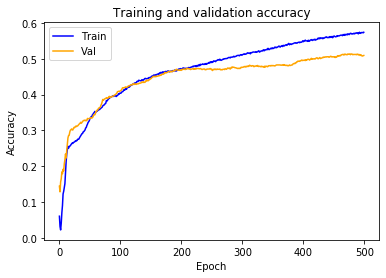

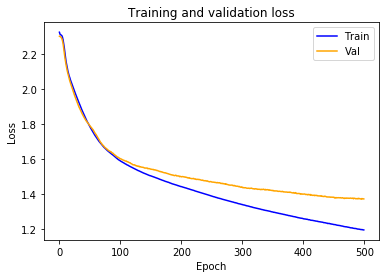

In [24]:
plot_history(history)

In [25]:
print(f"Final validation accuracy is: {history.history['val_accuracy'][-1]:.3f}")

Final validation accuracy is: 0.509


## Save model

In [26]:
file_path = git_root("models", "saved_models", "concatenated_final.h5")
model.save(file_path)